# Semi-Supervised Learning on Graphs

In this framework we use semi-supervised learning to classify the .wave files containing different words.
Our data consists in the 30 words. Thes 20 of the have to be recognized as what they are:  
    - up, down
    - zero, one, two, three, four, five ,six ,seven, eight, nine
    - go, stop 
    - left, rigth
    - no, yes
    - off, on
These words have to be classified as unknown:
    - bed
    - bird, cat, dog, mouse
    - tree
    - happy
    - marvin, sheila
    - wow

## 1. Import Libraries

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm
# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import pygsp

%matplotlib inline

plt.rcParams['figure.figsize'] = (17, 5)
pygsp.plotting.BACKEND = 'matplotlib'

2018-01-10 15:44:45,837:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



## 2. Load features

Load the feature matrix fom a .pickle file. To create a pickle file from the raw audio data we can use the test_featur python notebook. To Check the content we display the head of the panda data frame.

In [2]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_raw_10_1028_5.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         0  ../../Project/data/train/audio/bed/7846fd85_no...  7846fd85  bed   
1         0  ../../Project/data/train/audio/bed/51995cea_no...  51995cea  bed   
2         1  ../../Project/data/train/audio/bed/6a203e0e_no...  6a203e0e  bed   
3         1  ../../Project/data/train/audio/bed/0474c92a_no...  0474c92a  bed   
4         0  ../../Project/data/train/audio/bed/15c371c7_no...  15c371c7  bed   

      mfcc                                                ...              \
  raw_mfcc                                                ...               
         0        1        2        3        4        5   ...          40   
0 -518.607 -219.421 -180.718 -190.083  -236.29   68.603   ...    -10.4221   
1 -739.032 -568.546 -388.788 -395.509 -581.481  148.531   ...     2.73401   
2  -357.19 -169.471 -178.325 -164.575 -344.926    68.12   ...     8.01755   
3 -380.412 -164.692 -167.224 -183.987  -214.62  59.1119   ...      8.6284   
4 -434.501  -166.17 -54.1217 -147.915 -346.463   82.594   ...     15.6221   

                                                                           \
                                                                            
        41       42       43       44       45       46       47       48   
0  18.9384  24.1173  20.7235  18.4684 -5.64985  -19.628 -11.2644 -14.7974   
1  1.84458 -22.0633  -13.625 -21.5049 -4.46863  -27.791 -4.70561  0.37106   
2  6.55873  13.8552  13.5544 -8.86286  5.42373  14.5683  18.6055  21.0638   
3  32.4299  33.6695  35.5856  31.1413   19.121  9.22734  11.7204  14.5851   
4 -25.6132  -13.897 -41.8281  -10.606  4.44877 -27.8419 -22.7576 -11.8162   

            
            
        49  
0 -4.52644  
1 -18.8352  
2  12.8827  
3  17.2044  
4 -16.6746  

[5 rows x 54 columns]

## 3. Set the Graph

In this section we take the features and build from a wieght matrix From it. For thsi purpose the feature vectors belonging to every datapoint are compared using some distance metric (e.g. cosine distance). We sparsify the weight matrix using the k- nearest neighbour method and finally make sure that the weight matrix is symmetric.

Text(0.5,1.05,'Adjacency Matrix before Sparsifying')

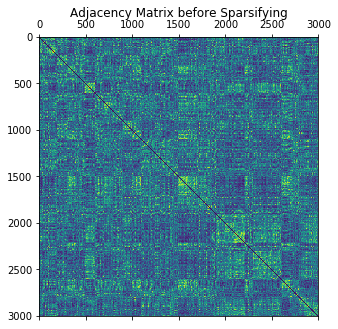

In [3]:
# Normalize Features
features = features_og['mfcc']
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

# Show sthe weight matrix
plt.matshow(weights)
plt.title('Adjacency Matrix before Sparsifying')

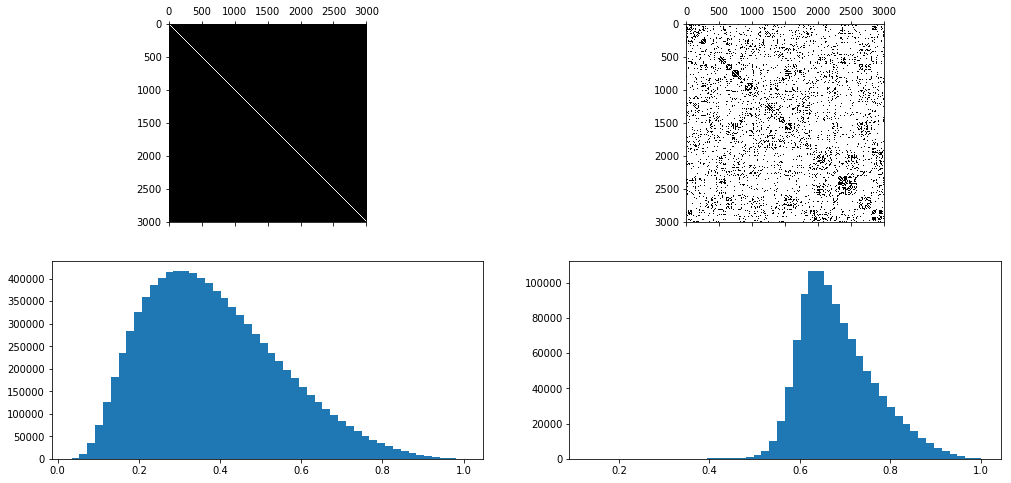

In [4]:
# Sparsify using k- nearest neighbours
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 400

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1]) 

## 4. Semi-supervised clustering

In this section we perform semi-supervised clustering on the training set, i.e. we assume that we only know a percentage of the labels of the points and infere the other labels by optimizing a certain cost function. From here on we're working with the python package PyGSP.

In [5]:
# Initialize Graph using the weights matrix
G = pygsp.graphs.Graph(weights)

# Compute the normalized Graph Laplacian corresponding to the above constructed graph
G.compute_laplacian('normalized')

# Compute the Fourier basis of the Laplacian
G.compute_fourier_basis(recompute=True)

Now we create a vector $\mathbf{y} \in \{1,2,...,30\}^{N}$ containing the label of each class (all words for now, i.e. 30 different labels). We then define the label vector as a graph signal and thus plot it on the graph.

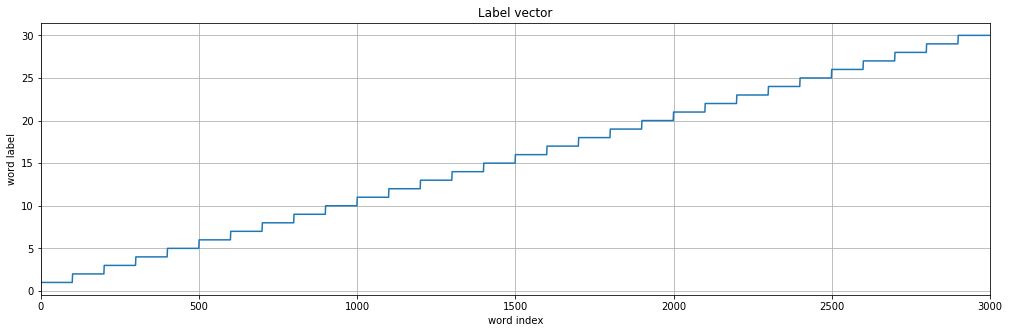

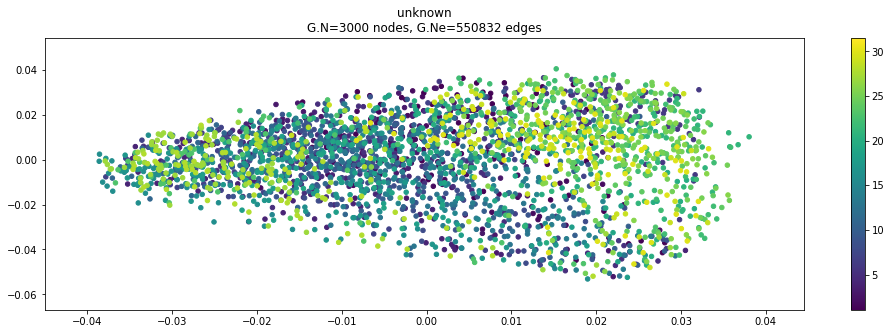

In [6]:
# Build Label vector
# Define class name vector, the index will correspond to the calss label
class_names = features_og['info']['word'].unique()
y = np.ones(len(features_og))
for i in range(0,len(class_names)):
    y +=(features_og['info','word'] == class_names[i]) * i
    
y.plot()
plt.grid()
plt.title('Label vector')
plt.xlabel('word index')
plt.ylabel('word label')
G.set_coordinates(G.U[:,1:3])
G.plot_signal(y, vertex_size=20)

We now want to split the label vector $\mathbf{y} \in \{1,2,...,30\}^{N}$ into a matrix $\mathbf{Y}\in \{0,1\}^{30\times N}$. Each row $i$ of the matrix $\mathbf{Y}$ contains an indicator vector $\mathbf{y_i}\in\{0,1\}^N$ for class $i$.

In [7]:
# From feature label to feature matrix
Y = np.zeros((int(np.max(y)),len(y)))
                 
for i in range(np.shape(Y)[0]):
    Y[i,:] = np.array(y == i+1, dtype = 'int64')

In the next function we compress our label matrix $\mathbf{Y}$, such that only a percentage of the labels remain known. We also create the masking matrix $\mathbf{M}\in\{0,1\}^{30\times N}$, with $||\mathbf{M}||_0 = 30\cdot N \cdot \text{perc}$, linking the original labels to the cormpessed ones. I.e. 

$$\mathbf{Y_{compr} = \mathbf{M} \odot \mathbf{Y}},$$

where $\odot$ signifies the elementwise matrix-matrix multiplication.

In [8]:
perc = 0.8
def prepare_observations(Y, perc):
    """Prepare observations, where p is the percentage of values to keep."""
    M = np.array(np.random.random_sample(np.shape(Y))>(1-perc),dtype = 'int64')
    Y_compr = Y*M
    return Y_compr, M

# Play with the percentage of observed values.
Y_compr, M = prepare_observations(Y, perc)

For visualizaton purposes we go back to a single, compressed label vector $\mathbf{y_{compr}}\in \{0,1,2,...,30\}^N$, where 0 now represents that we do not know the label of the node.

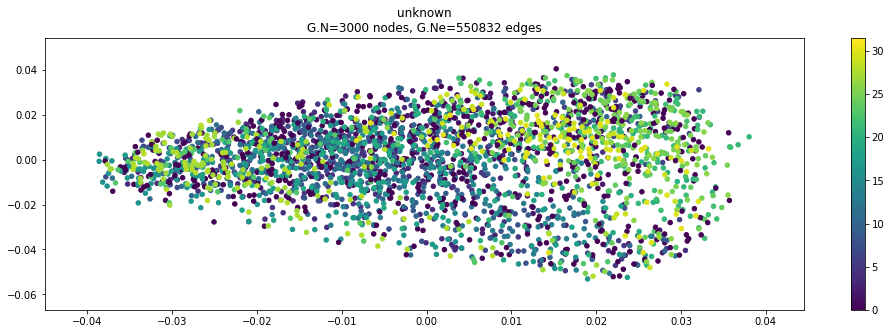

In [9]:
y_compr  = np.zeros(y.shape)
for i in range(Y.shape[0]):
    y_compr += Y_compr[i,:]*(i+1)
    
# Plot the label_vector with only 50% of its labels
G.plot_signal(y_compr, vertex_size=20)

In the next two cells we try to fill in the gaps to estimate a $\mathbf{\hat{x}}\in \{1,2,...,30\}$, which should ideally be equal to the original label vector $\mathbf{y}$. To achieve this we try to learn weighing vector $\mathbf{{x_i}} \in \mathbb{R}^N$ for each class $i$. The the higher the value $\mathbf{x_{i,j}}$, the higher the probability that node $j$ belongs to class $i$.  For this we solve the following optimization problem for each of the 30 classes, specified by $i\in \{1,2,...,30\}$.

$$ \underset{\mathbf{x_i} \in \mathbb{R}^{N}}{argmin} \quad \frac{1}{2}||\mathbf{M_i}(\mathbf{y_i}-\mathbf{x_i})||^2_2 + \frac{\alpha}{2} \mathbf{x_i}^T\mathbf{L}\mathbf{x_i} + \frac{\beta}{2}||\mathbf{x_i}||_2^2$$ 

The matrix $\mathbf{M_i}$ is defined as the diagonal matrix containing the $i^{th}$ row of $\mathbf{M}$ on its diagonal.
The first term of the cost function as seen above is the fidelity term, which makes sure that the estimated vector $\mathbf{x_i}$ is sufficiently close to the known entries of $\mathbf{y_i}$. The second term makes sure that the learned vector $\mathbf{x_i}$ is smooth on the graph. The last term is there to make sure that we solve for a low energy verctor, this is mainly to avoid the prolem to be ill-composed. The two factors $\alpha, \beta >0$ are hyperparameters which give weight to their respective term.<br>
<br>
For the above described optimization problem we can find an explicit solution. For this we first compute the gradient of the cost function with respect to $\mathbf{x_i}$.

$$\nabla f(\mathbf{x_i}) = -\mathbf{M_i}^T\mathbf{M_i}(\mathbf{y_i}-\mathbf{x_i}) + \frac{\alpha}{2} (\mathbf{L}^T +\mathbf{L})\mathbf{x_i} + \beta \mathbf{x_i}$$

Using the fact that $\mathbf{M_i}$ is a diagonal, symmetric matrix containing only '1' and '0', as well as the fact that $\mathbf{L}$ is simmetric, we can simplify $\nabla \mathbf{f}$ to

$$\nabla f(\mathbf{x_i}) = -\mathbf{M_i}(\mathbf{y_i}-\mathbf{x_i}) + \alpha \mathbf{L} \mathbf{x_i} + \beta \mathbf{x_i}.$$

To find the solution $\mathbf{x_i^*}$ to the optimization problem we set the gradient to 0 to obtain

$$\nabla f(\mathbf{x_i^*}) = 0 = \mathbf{M_i}(\mathbf{y_i}-\mathbf{x_i^*}) - \alpha \mathbf{L} \mathbf{x_i^*} - \beta \mathbf{x_i^*},$$

and thus

$$\mathbf{M_i y_i} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{x_i^*}.$$

$\mathbf{I}_{NN}$ is the identity matrix of size $N \times N$. Introducing $\mathbf{y_{i,compr}} = \mathbf{M_i y_i}$ we can write

$$\mathbf{y_{i,compr}} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{x_i^*}.$$

We define the matrix $\mathbf{A} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN})$ and analyse its invertibility.
We know that the Laplacian $\mathbf{L}$ is positive semi-definite (PSD), which means that all its eigenvlues are $\geq 0$. $M_i$ simply adds '1' to some of that eigenvalues, unfortunately not to all of them and thus it is not a sufficient criteria to render $\mathbf{A}$ full-ranlk an thus invertible. For this prupose we introduce the $l_2$-prior which adds $\beta >0$ to each eigenvalue, which makes $\mathbf{A}$ psoitive definite and thus invertible. I.e. by controlling $\beta$ our problem is well-posed and a unique solution $\mathbf{x_i^*}$ can be found.

$$\mathbf{x_i^*} = \mathbf{A^{-1}}\mathbf{y_{i,compr}}$$

Having found an $\mathbf{x_i}$ for every class $i$, we then build a matrix $\mathbf{X}\in \mathbb{R}^{30\times N}$, containing learned vectors $\mathbf{x_i}$ as its rows. The final labelling vector $\mathbf{\hat{x}}\in \{1,2,...,30\}$ is obtained by finding the row $i$ for each column $j$ of $\mathbf{X}$ in which the value is maximal and the index $i$ of the corresponding row will be the class $i$ of the datapoint (node) corresponding to the column $j$.

$$\mathbf{M_i y_i} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{x_i^*}.$$

$\mathbf{I}_{NN}$ is the identity matrix of size $N \times N$. Introducing $\mathbf{y_{i,compr}} = \mathbf{M_i y_i}$ we can write

$$\mathbf{y_{i,compr}} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{x_i^*}.$$

We define the matrix $\mathbf{A} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN})$ and analyse its invertibility.
We know that the Laplacian $\mathbf{L}$ is positive semi-definite (PSD), which means that all its eigenvlues are $\geq 0$. $M_i$ simply adds '1' to some of that eigenvalues, unfortunately not to all of them and thus it is not a sufficient criteria to render $\mathbf{A}$ full-ranlk an thus invertible. For this prupose we introduce the $l_2$-prior which adds $\beta >0$ to each eigenvalue, which makes $\mathbf{A}$ psoitive definite and thus invertible. I.e. by controlling $\beta$ our problem is well-posed and a unique solution $\mathbf{x_i^*}$ can be found.

$$\mathbf{x_i^*} = \mathbf{A^{-1}}\mathbf{y_{i,compr}}$$

Having found an $\mathbf{x_i}$ for every class $i$, we then build a matrix $\mathbf{X}\in \mathbb{R}^{30\times N}$, containing learned vectors $\mathbf{x_i}$ as its rows. The final labelling vector $\mathbf{\hat{x}}\in \{1,2,...,30\}$ is obtained by finding the row $i$ for each column $j$ of $\mathbf{X}$ in which the value is maximal and the index $i$ of the corresponding row will be the class $i$ of the datapoint (node) corresponding to the column $j$.

In [10]:
def solve(Y_compr, M, L, alpha, beta):
    X = np.ones(Y_compr.shape)
    for i in range(Y_compr.shape[0]):
        Mask = np.diag(M[i,:])
        y_i_compr = Y_compr[i,:]
        X[i,:] = np.linalg.solve((Mask+alpha*L+beta),y_i_compr)
        
    return X

def adapt_labels(x_hat):
    # Real accuracy considering only the main words :
    class_names_list = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    mask_names_main = [True if name in class_names_list else False for name in class_names]
    index_names_main = [i for i in range(len(mask_names_main)) if mask_names_main[i] == True]
    inverted_index_names = dict(zip(index_names_main,range(len(index_names_main))))

    # Creating the label names :
    class_names_main = class_names[mask_names_main].tolist()
    class_names_main.extend(["unknown"])

    # Adapting the labels in the test and prediction sets :
    return np.array([inverted_index_names[int(x_hat[i])] if x_hat[i] in index_names_main else len(class_names_main)-1 for i in range(len(x_hat)) ])

In [11]:
# Solve for the matrix X
X = solve(Y_compr, M, G.L,alpha = 1e-3, beta  = 1e-7)

# Go from matrix X to estimated label vector x_hat
x_hat = np.argmax(X,axis = 0)+np.ones(X[0,:].shape)

# Adapt the labels, whee all words of the category "unknown" are unified
x_hat_adapted = adapt_labels(x_hat)
y_adapted = adapt_labels(y)

# Compue accuracy in predicting unknown labels
M_inv = np.array(np.sum(Y_compr,axis = 0)==0,dtype = 'int64')
pred = np.sum(x_hat_adapted[M_inv==1]==y_adapted[M_inv==1])/x_hat_adapted[M_inv==1].shape[0]
print(pred)

0.791798107256


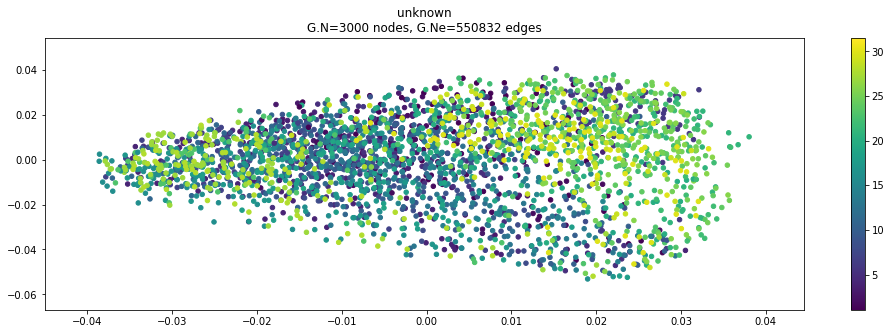

In [12]:
# PLot estimated labels
G.plot_signal(x_hat, vertex_size=20)